In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
matplotlib.rcParams.update({'font.size': 22})

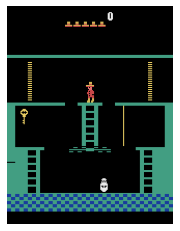

In [5]:
env = gym.make("MontezumaRevenge-v0")
env.reset()


plt.imshow(env.ale.getScreenRGB2())
plt.axis("off")
plt.show()

In [3]:
def plot_norms(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        #plt.fill_between(x, mu + np.max(ys, axis=1) , mu - np.min(ys, axis=1), alpha=0.2, color=color)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)

def plot_fgsm(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2)
    
    plt.xticks(rotation=-45)
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_sigma.pdf', format='pdf', dpi=1000)

In [4]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

def plot_fgsm_minmax(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.xticks(rotation=-45)

    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_minmax.pdf', format='pdf', dpi=1000)

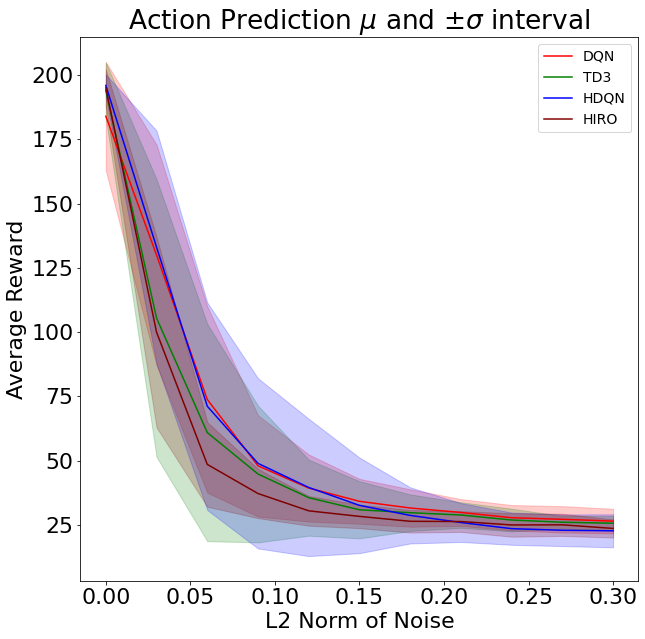

In [6]:
import json
plot_norms([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

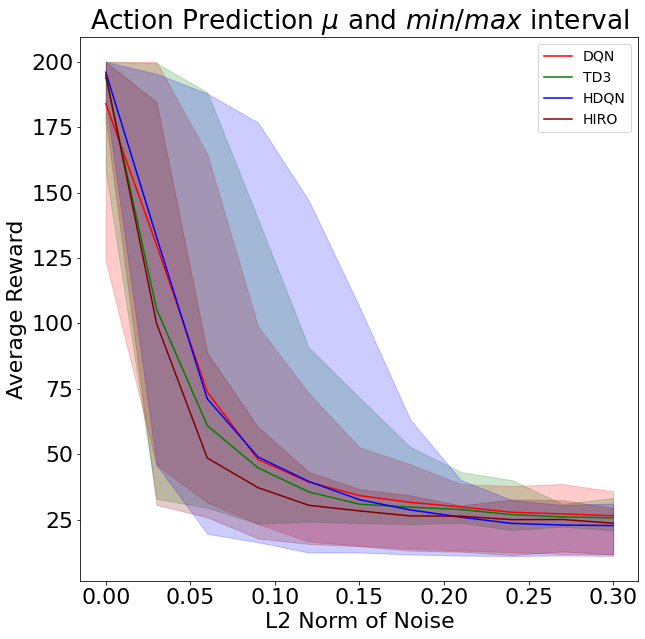

In [7]:
import json
plot_norms_minmax([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

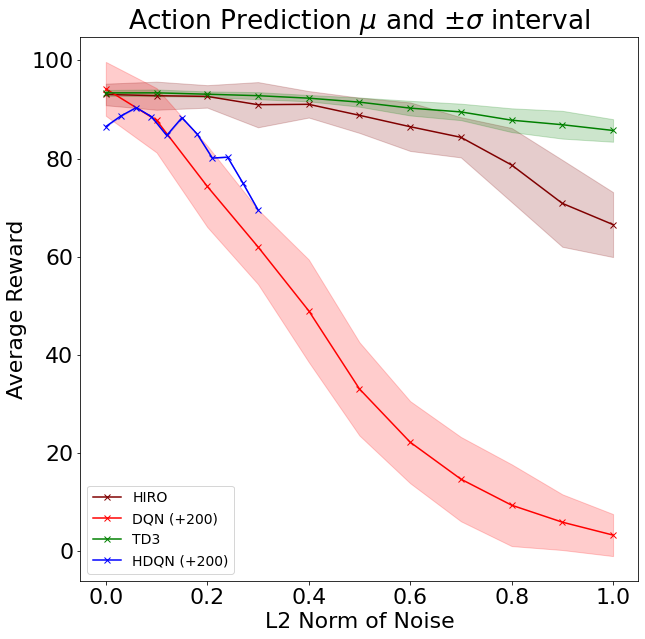

In [65]:
import json
dqn = json.load(open("car/noise/dqn_episodes.json"))
for i in dqn.keys():
    for ii in range(len(dqn[i])):
        dqn[i][ii] += 200

hiro = json.load(open("car/noise_hrl/hiro_episodes.json"))
hiro = hiro['both']

hdqn = {0.0: [-113.48], 0.03: [-111.3], 0.06: [-109.62], 0.09: [-111.45], 0.12: [-115.29], 0.15: [-111.67], 0.18: [-114.99], 0.21: [-119.91], 0.24: [-119.71], 0.27: [-124.96], 0.3: [-130.46]}
for i in hdqn.keys():
    for ii in range(len(hdqn[i])):
        hdqn[i][ii] += 200

plot_norms([\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO"),\
    (dqn, "red", "DQN (+200)"),\
    (json.load(open("car/noise/td3_episodes.json")), "green", "TD3"),\
    (hdqn, "blue", "HDQN (+200)")
   ])

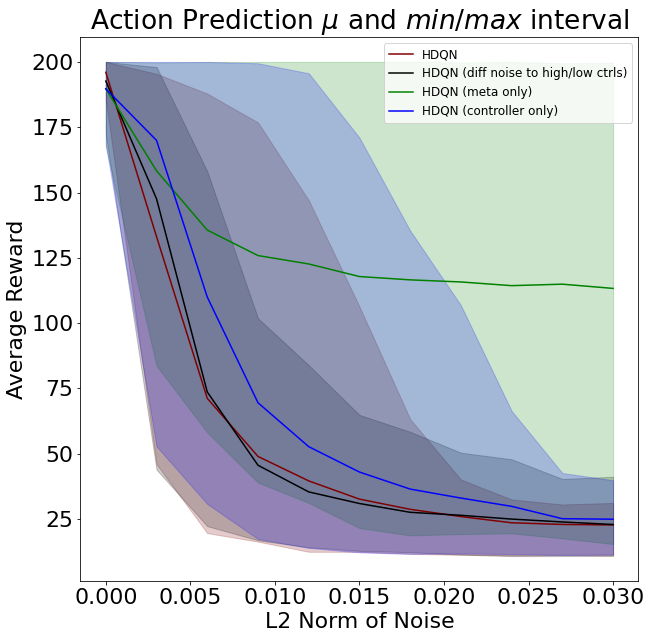

In [24]:
import json
plot_norms_minmax([\
    #(json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
    #(json.load(open("absolute_noise_different/hiro_episodes.json")), "black", "HIRO (diff noise to high/low ctrls)"),\
    #(json.load(open("absolute_noise_meta_only/hiro_episodes.json")), "green", "HIRO (meta only)"),\
    #(json.load(open("absolute_noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (controller only)")
    (json.load(open("absolute_noise/hdqn_episodes.json")), "maroon", "HDQN"),\
    (json.load(open("absolute_noise_different/hdqn_episodes.json")), "black", "HDQN (diff noise to high/low ctrls)"),\
    (json.load(open("absolute_noise_meta_only/hdqn_episodes.json")), "green", "HDQN (meta only)"),\
    (json.load(open("absolute_noise_ctrl_only/hdqn_episodes.json")), "blue", "HDQN (controller only)")
  ])

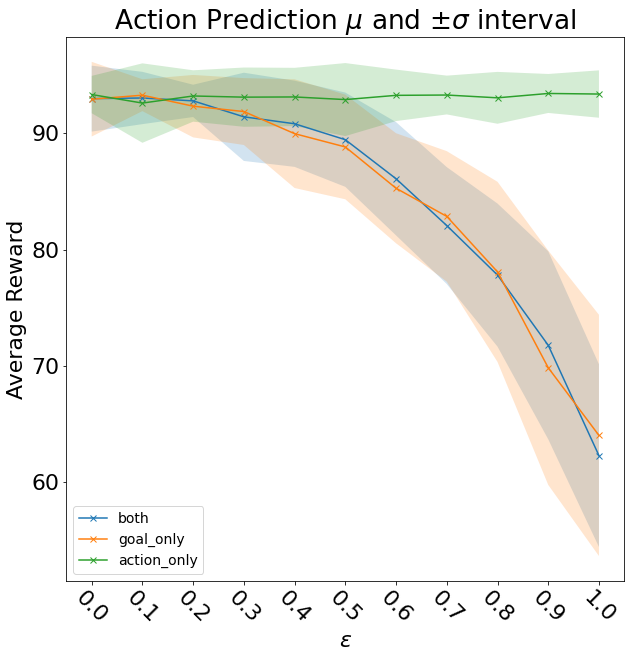

In [53]:
import json
plot_fgsm(json.load(open("car/noise_hrl/hiro_episodes.json")))

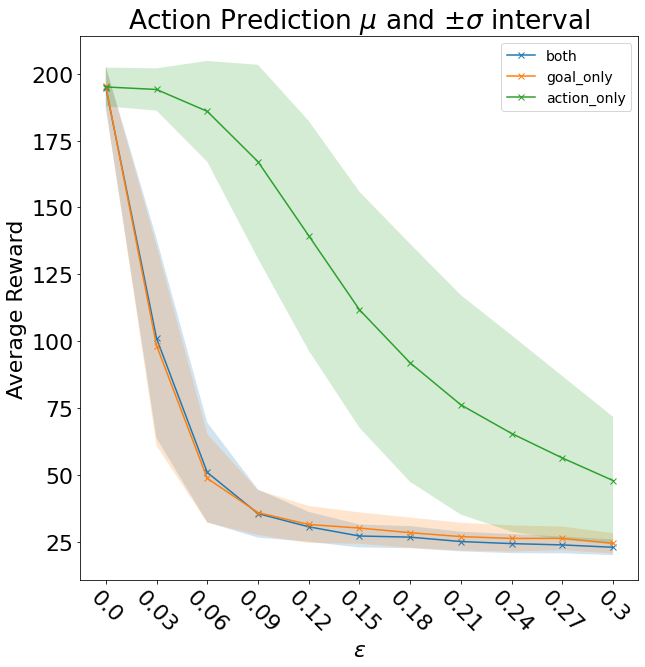

In [51]:
import json
plot_norms([\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO (same noise to both ctrls)"),\
    (json.load(open("car/noise_diff/hiro_episodes.json")), "black", "HIRO (diff noise to each ctrls)"),\
    (json.load(open("car/noise_meta_only/hiro_episodes.json")), "green", "HIRO (noise to meta ctrl only)"),\
    (json.load(open("car/noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (noise to ctrl only)")
   ])

In [11]:
hiro1 = {'both': {0.0: [93.8314225698464, 93.92023067366725, 94.53884111025145, 94.01082026783635, 93.48687742316791, 93.91282252589593, 94.3153990968144], 0.025: [92.17632844530289, 93.34774087646333, 94.64143158244802, 93.60997356164573, 93.97629040562319, 94.18258756697816, 93.1867165526663], 0.05: [94.11130100837583, 93.40901651286698, 94.62878026850436, 93.2906246022272, 94.23750783985804, 93.6182783282148, 93.03992394780971], 0.07500000000000001: [88.9313309946977, 93.49406526627003, 94.54752369540225, 93.31618631766722, 94.07826455667599, 93.59474880909913, 92.89143342909671], 0.1: [80.21431033832087, 93.30012491927877, 94.34648252483285, 93.36557139416455, 94.05981512634658, 93.79654089681667, 92.62191497739838], 0.125: [73.13969163422374, 93.37421234607258, 94.01113445761983, 93.22878623801743, 93.65822135317843, 93.2322534255169, 92.1907092516812], 0.15000000000000002: [76.26659475589946, 91.1981647940952, 93.68409850605438, 92.74118526567257, 93.46410811448725, 92.85181701382959, 91.80233296838465], 0.17500000000000002: [29.935284081260683, 71.6461792926723, 93.18060970895799, 90.0871254203134, 93.68750531095183, 91.64791451284995, 91.35006108991801], 0.2: [36.97014612885636, 83.69596438148403, 92.6666168609277, 91.96227527260909, 93.56948344200316, 90.83054956953309, 76.97401078541029], 0.225: [37.532592276477956, 68.38731739335024, 92.66529599933924, 90.81385153907908, 92.72347907723866, 85.33513098003947, 70.86720672281226], 0.25: [40.04614878834503, 70.65389130310373, 91.35153722779408, 84.62213519582953, 92.39786240378858, 89.90810026833981, 74.03517221560045], 0.275: [55.847419959602966, 67.60408149895461, 91.240601480054, 73.60070969353369, 92.05241147276007, 85.3261192148455, 47.650639897358154], 0.30000000000000004: [49.5706450185435, 56.477136106494555, 91.3806237993104, 67.53615170872241, 91.69786233908792, 67.57214214298466, 40.54388739964276]}, 'goal_only': {0.0: [93.91293568381681, 93.71137071411398, 94.55726525181552, 94.1345034901812, 93.85570590457053, 92.94218618577317, 94.02445949652284], 0.025: [92.90948573382737, 92.643012479752, 94.64914903408535, 93.6996939601111, 94.00199484401551, 94.01342374009519, 93.66163185799789], 0.05: [92.0277728563186, 93.71143274429201, 94.61013003297622, 93.72757796442156, 93.9849318798413, 93.88013129248019, 93.3068775245618], 0.07500000000000001: [84.22830292664293, 93.27938770808345, 94.5700588926662, 92.89199256650423, 94.41279540784956, 93.66456843242959, 93.01478908012628], 0.1: [78.29085011081722, 93.27710347401923, 94.39263051828435, 93.31375824914643, 94.02666321509385, 92.62769430203703, 92.17475891986534], 0.125: [78.22363723844127, 93.31216795149801, 94.23744010248986, 92.92379219576944, 94.08557378694559, 93.34142905191312, 92.24996918190962], 0.15000000000000002: [57.06771978990634, 88.9920978641728, 93.82440458747519, 92.73008734554877, 93.8133276980084, 90.12474034958093, 91.9514632396879], 0.17500000000000002: [20.86183588826175, 74.67422706535734, 93.01963688547791, 90.31651544799836, 93.69076264826818, 90.49709808032082, 91.23880342331469], 0.2: [34.22683492313501, 68.48546700908986, 92.39206846832775, 91.96431695197727, 93.53600348893717, 81.00157868266446, 78.05758495289955], 0.225: [37.75409434371617, 61.44398150617264, 91.90410575449089, 91.99268543851403, 93.1852735393575, 85.73919846395944, 73.00262166866962], 0.25: [44.55063979879333, 54.37015446259573, 91.45911549619535, 76.72364939651148, 92.58638179046869, 80.74715231170357, 68.22503789419883], 0.275: [49.94784806064659, 58.547162191373616, 91.07163307318642, 58.39663712608058, 91.93728938842786, 76.75822347502913, 49.818247896794745], 0.30000000000000004: [43.93830914389634, 49.45985017252759, 91.55340736282102, 50.30938872654204, 91.68680345591183, 71.48395980174303, 40.602299080574184]}, 'action_only': {0.0: [94.02433001678769, 94.02252251781391, 94.60227062391198, 93.97466306387031, 93.57608746456904, 94.02791979469652, 94.01021749093056], 0.025: [92.82531924057963, 93.81892122029778, 94.60007744206911, 94.24513349860328, 93.62351049704897, 93.84225988815005, 94.50056309243196], 0.05: [92.99729393387297, 93.57028796114678, 94.65420012448351, 94.02418424146907, 93.75607098579844, 93.91483792969758, 94.1349183517037], 0.07500000000000001: [94.09321850456205, 93.5187122548122, 94.60327743427784, 94.02727206436207, 93.46726591337537, 94.11281690519547, 94.10553485912953], 0.1: [93.88473909864348, 93.99484005974178, 94.58485311724137, 94.21982894669847, 93.78758359970296, 93.86089190985953, 94.06510145264888], 0.125: [93.88633997101505, 93.59909787135352, 94.65015968722619, 94.2268815940769, 93.93352863794011, 93.91606557277589, 94.20808242427852], 0.15000000000000002: [94.02703532774656, 93.48755998284149, 94.65083960771125, 93.9745825930205, 93.69210918084077, 93.84025064160843, 93.92889979335959], 0.17500000000000002: [92.83067669103451, 92.86882654934647, 94.61235728388965, 93.99599749301366, 93.80473271654074, 93.82709852430868, 94.07746505353032], 0.2: [93.65533160239669, 93.5406028191089, 94.62798080371951, 94.26085175780437, 93.56240225022799, 93.75269895518268, 94.21808451616442], 0.225: [93.90424288523792, 93.86837363320967, 94.61328694629707, 94.32223084986622, 93.7948806246513, 93.91233089696414, 93.88529469144248], 0.25: [94.11884709177758, 93.78150462189947, 94.56056817506587, 93.91469319532487, 93.894741725221, 93.90451492622815, 94.12583877279373], 0.275: [93.9909963031579, 94.02386725486544, 94.59882760976377, 94.1406063361252, 93.57655739921405, 94.07978398612622, 94.34499654726604], 0.30000000000000004: [93.92402042480325, 93.76378637670264, 94.6315655330152, 94.19889854342877, 93.5449384269182, 93.88831335562418, 93.97132838236607]}}
hiro2 = {'both': {0.0: [94.65581239573456, 92.66751295860162, 86.62242743271442], 0.025: [94.62823837986264, 92.19800348037879, 89.46198138438696], 0.05: [94.68437191896294, 91.59844014872206, 89.2322777128791], 0.07500000000000001: [94.5267458479354, 91.22928898094948, 89.43479372687081], 0.1: [94.23229243924594, 91.69083195541367, 89.01962934425872], 0.125: [93.8771682160986, 91.04619001625866, 88.81757861165994], 0.15000000000000002: [93.65306888549547, 91.0207930933348, 88.74376190816747], 0.17500000000000002: [93.18806652712509, 90.24393572768659, 88.72404389191149], 0.2: [93.1758649528023, 90.28213235114976, 88.74485048598874], 0.225: [92.6778994586106, 86.28136008164589, 88.7990495816969], 0.25: [92.28091107339243, 80.86364002838398, 88.87912624374654], 0.275: [92.13680546360224, 71.54395190299579, 88.81051879429383], 0.30000000000000004: [88.88953604688015, 56.49340783169192, -15.003525186455638]}, 'goal_only': {0.0: [94.66496683158131, 92.7167902316335, 87.62204297361313], 0.025: [94.63388995793433, 92.11713100313071, 89.35077184379263], 0.05: [94.49777597194367, 91.72862132815693, 88.71640093552273], 0.07500000000000001: [94.26435170285818, 91.09520456654693, 86.40854480272225], 0.1: [94.27916916494416, 91.21495291560237, 89.0609774890319], 0.125: [94.04924962658087, 90.97017957601784, 88.96973595792008], 0.15000000000000002: [93.70947021697769, 90.55369649671924, 88.74698389942272], 0.17500000000000002: [93.43021056655917, 90.47768604882005, 88.73432388054024], 0.2: [93.06388811112782, 87.29151766097348, 88.71945421322069], 0.225: [92.93691694777897, 86.05919770646868, 88.80936507736996], 0.25: [92.55307224472959, 76.69927967152933, 88.88920289504107], 0.275: [92.2056230618204, 65.27993592410779, 88.92128788789027], 0.30000000000000004: [91.23567962173819, 59.90810346785916, -15.061038384689844]}, 'action_only': {0.0: [94.45417464279332, 92.17920115569815, 88.85416414385594], 0.025: [94.57309196515227, 92.21591354035573, 84.61669222719864], 0.05: [94.64678434496336, 92.5627862591971, 85.54904339382469], 0.07500000000000001: [94.57969177812201, 92.61028871885895, 84.5644783487915], 0.1: [94.6223351031618, 92.41385684203847, 84.63204434460644], 0.125: [94.65996735891903, 92.47317017082327, 87.62619736015547], 0.15000000000000002: [94.63808356107651, 92.44749306492055, 88.75387634064069], 0.17500000000000002: [94.58667003140135, 92.30472894056454, 90.7241781768586], 0.2: [94.5269651007118, 92.23908565167898, 86.92506616351828], 0.225: [94.65965016048403, 92.7756064309396, 89.76020713771649], 0.25: [94.34936455380355, 92.80661530235864, 86.81803010691041], 0.275: [94.63280516822749, 92.63740874297892, 86.86167738104417], 0.30000000000000004: [94.64195680337836, 92.1948340611795, 89.60262617611345]}}

In [12]:
hiro = {}
for i in hiro1.keys():
    hiro[i] = {}
    for ii in hiro1[i].keys():
        hiro[i][ii] = list(np.concatenate([hiro1[i][ii], hiro2[i][ii]]))

In [45]:
for i in hiro1.keys():
    hiro1[i].pop(0)
    hiro1[i].pop(12 - 1)
    hiro1[i].pop(13 - 2)
    hiro1[i].pop(16 - 3)
    hiro1[i].pop(17 - 4)
    #hiro1[i][ii].pop(18 - 4)
    #hiro2[i][ii].pop(0)
    hiro2[i] = np.array(hiro2[i])[[0, 1, 2, 3, 7, 8, 11]]
        
hiro = {}
for i in hiro1.keys():
    all_i = list(np.concatenate([hiro1[i], hiro2[i]]))
    hiro[i] = all_i

In [9]:
len(hiro['both'][0.0])

10

In [13]:
import json
json = json.dumps(hiro)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [48]:
import json
eps = {0.0: [94.02214846112338, 92.46604482439199, 94.6267986075503, 93.7934701673048, 93.93178666611402, 93.86893321164284, 93.79741066379066, 94.62343849865329, 92.76678048062745, 86.7583094058671], 0.1: [92.91088280148409, 93.68347903397819, 94.49249989545106, 94.2155443141096, 93.6696586314285, 93.4861958953975, 94.1663301430064, 94.60826004173154, 92.42530538745716, 84.43882899515947], 0.2: [88.73957680964396, 93.81050924564418, 94.04547692415295, 93.67467012104251, 93.67737534492566, 93.79105459966853, 94.28409525632301, 94.2520755005166, 92.78049834214704, 87.62139792585401], 0.30000000000000004: [80.45426127347909, 93.38912613646136, 93.7332797927102, 93.33203009462463, 93.46655614604009, 92.55065630130093, 93.34036408923366, 94.02631587584222, 92.09780125084853, 83.35997645017231], 0.4: [88.48766995509122, 93.04580007729498, 93.18029098180074, 91.87627389290154, 93.13296346352895, 92.32439408611306, 90.75530544308802, 91.97837388510492, 91.76023136935567, 83.99324559158613], 0.5: [84.24853736617013, 86.48651477691469, 91.38706386382927, 90.8980118895532, 89.66755739704604, 91.45148504420872, 92.21782375862544, 91.99241161183922, 88.90055789228727, 80.89366879082317], 0.6000000000000001: [79.05334451963672, 91.08012965855447, 91.26632336151899, 85.45706036858147, 89.14477716489785, 85.78518138078442, 88.18627125413494, 91.08119818654235, 87.88031043128166, 75.95015373937156], 0.7000000000000001: [72.85193338894335, 85.68801342770628, 86.72114165357952, 87.21206206047007, 87.51584332313536, 84.30173794685183, 84.76094640096385, 84.47797202965195, 87.07525430153964, 82.6538855502491], 0.8: [74.69679308765011, 73.33480060972536, 82.99654073723643, 79.6677018418459, 90.16974458953422, 76.96498834016839, 81.54680433694085, 82.00333287789798, 84.50665166209423, 60.86937811959101], 0.9: [56.211924336018576, 75.91297982551082, 81.28526851250881, 80.49840036459963, 63.44069216871539, 72.82106007357726, 74.12776568523137, 68.63150499434045, 78.96917852273104, 56.64649639626633], 1.0: [59.01015903604335, 69.78585499021216, 81.19744106451509, 64.94798885182618, 66.08804419415326, 66.4714337672079, 64.86982633884782, 64.32627278087584, 72.5000315836005, 56.06392144870873]}
json = json.dumps(eps)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [52]:
import json
# both, goal_only, action_only
eps = {
    'both': {0.0: [93.71854677796182, 93.733955016213, 94.53222754596733, 94.2928513109786, 93.48236569117334, 93.91256570044598, 94.08568890115133, 94.71121751356462, 92.73065536779328, 84.62770986525229], 0.1: [94.1561725378607, 93.84342062352366, 94.35400615216945, 93.96426944803385, 92.74454467426456, 93.74776676844125, 94.00756383516533, 94.61731756908566, 92.36779862920355, 86.58509302451702], 0.2: [90.79897596794927, 93.56180478985999, 93.6225371771608, 93.80426698199045, 93.56955913037052, 92.55100821014462, 93.41164063592169, 94.39664540146632, 92.45000302431737, 89.748083524907], 0.30000000000000004: [84.3688637035313, 93.47456422515916, 93.80339079964865, 93.34630076372703, 92.47680467012403, 93.54236362946911, 93.62839514225999, 93.96589484185468, 92.10687150905137, 83.47071164788069], 0.4: [84.45073110011441, 93.4361085973489, 93.0384489639039, 93.0633545909846, 93.0402603273106, 91.21948941632172, 92.78217139541287, 93.76453728201666, 90.49435305266734, 82.92456877033105], 0.5: [88.38314904062052, 92.52640561227223, 92.68493026312821, 91.92534523928585, 88.34027011051698, 90.29492623925944, 92.0893047242276, 91.98747649441435, 87.72326432915386, 78.55124390061833], 0.6000000000000001: [78.04229531815609, 91.20291012579966, 91.47692697515544, 87.41848871224128, 85.66149602621952, 83.37244691474834, 87.58393411487309, 89.07899274864486, 90.01944746858439, 77.06708446249912], 0.7000000000000001: [71.67194475009654, 85.9377952797025, 88.9839219704068, 81.80632522900991, 82.4391870256026, 77.30678692283205, 87.87172835554719, 84.4768108895242, 82.47964117223648, 77.67729014747755], 0.8: [69.3790644730948, 78.31535901452867, 88.18454474210739, 80.49068174032976, 78.96501277294271, 67.94884331988501, 81.43097163061053, 78.728203690688, 83.609419971774, 71.0251950160587], 0.9: [53.03670017795054, 69.97698462867156, 81.3511620483026, 71.99758215471445, 71.32572249578313, 81.05091387790772, 75.9605298823621, 69.6224140897447, 78.70605633444417, 64.65609019528002], 1.0: [46.7059416631126, 64.42667179918533, 76.87535836910202, 63.70224871495952, 64.07969268162056, 59.43529383643564, 66.85438452572745, 66.40621008559958, 62.315835948369774, 51.98490642716622]},
    'action_only': {0.0: [92.84385725861983, 94.01850260126515, 94.57610118787348, 94.06747640446123, 93.79549406328957, 94.08147622371578, 93.87025529051338, 94.49778407006889, 92.7510731404678, 88.83969327521207], 0.1: [92.81737694140213, 93.4801967380133, 94.58862958725474, 94.03698755218574, 93.72566203945051, 93.8409144262479, 93.67806316884285, 94.65993089582565, 92.66772239049696, 82.51830053452969], 0.2: [93.86329958986066, 93.83864999895691, 94.63176353153801, 93.94626612178563, 93.8600671355677, 93.91813177908051, 94.24870083338703, 94.59085998887954, 92.40129681845123, 86.81853067450737], 0.30000000000000004: [94.00209450946478, 94.01588910837714, 94.62125943188748, 93.81662519517484, 93.6213578902633, 93.9875762106575, 94.23287610270877, 94.60311777555088, 92.55850715241642, 85.64716957951383], 0.4: [93.90816574586349, 93.89998325778666, 94.60767767883986, 94.26698859998363, 93.66115354557373, 93.92689857192107, 93.86695078837874, 94.6384050082636, 92.73282413253446, 85.76913027803468], 0.5: [93.81550420688966, 93.74386884724696, 94.61036607890526, 94.08791411361607, 93.7689180636279, 94.02724293360048, 94.32101588773206, 94.48769584406176, 92.53080162546108, 83.62802797278988], 0.6000000000000001: [93.91374736001225, 93.77002160599852, 94.63208493717019, 94.30489569185018, 93.58409838059065, 94.01515673636983, 94.45555255926662, 94.3369439600516, 92.8614012543832, 86.78649792669258], 0.7000000000000001: [92.77606967914164, 94.0524815606488, 94.59051251096865, 94.03093226389943, 93.79620606666498, 93.87895953117577, 94.10397014995138, 94.52432796948811, 92.50779845936782, 88.67091612333189], 0.8: [92.96501752136868, 93.91074465866332, 94.60122687195843, 94.01853203076026, 93.45840078292044, 93.89454807665673, 93.85493046982936, 94.50104714021208, 92.74985903802202, 86.57612376978854], 0.9: [93.96625057252558, 93.81475343602828, 94.58513661181904, 94.22961656093015, 93.62553166371475, 93.94181766540511, 94.07958835836193, 94.58335068761497, 92.84567714303648, 88.60387990297251], 1.0: [93.78522813567665, 94.27955916045175, 94.59430336741656, 94.2248371281501, 93.85462799504771, 94.06483399314047, 94.10839101835188, 94.68298585254234, 92.71693619593464, 87.46541517866407]},
    'goal_only': {0.0: [93.84735112165377, 94.01368878041104, 94.59882218528121, 94.32547125348006, 93.77220437901678, 93.98654305624859, 94.19367012838119, 94.62007536572783, 92.55441647769295, 83.44231377032438], 0.1: [91.96161437943367, 93.85400499304062, 94.3080542778834, 93.5621228460896, 93.90578112508092, 93.87949122466733, 94.14870610831919, 94.67284703504389, 92.64111397579451, 89.85531811482801], 0.2: [87.6470437385984, 93.73440099914068, 94.2197004346482, 94.02705602123629, 92.78621881208123, 93.86846072805123, 93.73875547634107, 94.34239178956742, 92.40782911752859, 86.57327235408162], 0.30000000000000004: [87.64604546978117, 93.46331922851236, 93.55264928784307, 93.33491955069708, 93.39530235026066, 92.56357533565479, 93.56810446766426, 94.12803898188739, 92.02680469572215, 85.04645975228914], 0.4: [82.28885099771983, 93.13336922185073, 92.74699557203155, 92.65536269510987, 93.08811299095323, 88.79298359010521, 93.05842466701846, 93.45471977319126, 90.58727987622251, 79.89938292119258], 0.5: [84.24833004123533, 91.55076447641024, 92.68823698638009, 88.9654840767474, 89.23851054159962, 89.29174860551262, 92.25750765492546, 92.70217809797732, 89.9371863366119, 77.38665350846925], 0.6000000000000001: [79.98867379601444, 90.14294473331046, 88.52953570121275, 86.35368120752368, 84.7113705020232, 85.92072096714405, 89.35564649042395, 88.14633587212495, 85.92378128098362, 73.67673199203483], 0.7000000000000001: [73.82575091751588, 86.73935797316517, 87.96708064898499, 84.6819331098375, 86.57619139242068, 83.21751093634533, 81.74076644274129, 87.4206544566479, 85.57242953316825, 70.79368872367753], 0.8: [64.56126897762347, 82.54754208099402, 88.40403553348953, 78.87342695370282, 74.67952709489299, 73.8579889005248, 86.65957979829037, 83.03955299951096, 82.20385001072069, 66.01414136888617], 0.9: [46.0148448055563, 75.32347593020958, 82.41616359582065, 81.50579642051923, 64.14009128869708, 63.50132850272897, 75.05719551385151, 70.33795670545908, 73.43231930000894, 66.64626496390245], 1.0: [37.78962043663363, 66.45719498882666, 76.661222807842, 59.84041315301121, 64.80464488941064, 62.4830149642176, 70.92686691887276, 69.21003785981513, 73.72586163872964, 58.262871780997614]}
}
json = json.dumps(eps)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [34]:
import json
np.mean(json.load(open("cartpole/noise/dqn_episodes.json"))["0.0"])

184.042

***
Things for making gifs:

In [ ]:
# tricks to make rendering work in Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# goal: 0 to 1; action: 0 to 1
def append_action_goal_to_screen(img, goal, action):
    img = np.array(img[:,::-1])
    max_width = 100
    height = 50

    # omit these two lines for HIRO
    goal = goal * 2 - 1
    action = action * 2 - 1

    if goal < 0:
        cv2.rectangle(img, (int(max_width + goal * max_width), 0), (max_width, height), (255, 0, 0), -1) # goal
    else:
        cv2.rectangle(img, (max_width, 0), (int(max_width + goal * max_width), height), (255, 0, 0), -1) # goal
    if action < 0:
        cv2.rectangle(img, (int(max_width + action * max_width), height), (max_width, 2 * height), (0, 0, 255), -1) # action
    else:
        cv2.rectangle(img, (max_width, height), (int(max_width + action * max_width), 2 * height), (0, 0, 255), -1) # action
    return img

In [ ]:
def render_single_episode(hdqnAgent): # HDQN
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    max_episode_length = 200
    num_episodes = 100

    frames = []

    overall_reward = 0
    observation = env.reset()

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal_i, action_i))

            observation, reward, done, _ = env.step(action_i)

            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = (goal_i == action_i)

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    return frames, overall_reward

In [ ]:
def render_single_episode(agent): #HIRO
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 200
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 1

    frames = []

    overall_reward = 0
    observation = env.reset()
    # set a large starting angle
    env.state[2] = -env.observation_space.high[2] / 2.0
    observation = np.array(env.state)

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = agent.select_goal(state, False)

        goal_done = False
        while not done and not goal_done:
            action = agent.select_action(state, goal, False)

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal, action))

            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            next_goal = agent.h(state, goal, next_state)
                              
            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = agent.goal_reached(state, goal, next_state)

            state = next_state
            goal = next_goal
    return frames, overall_reward

In [ ]:
frames, overall_reward = render_single_episode(agent)
print(overall_reward)

import pickle
with open('frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

In [ ]:
with open('frames.pkl', 'rb') as f:
    frames = pickle.load(f)
with open('openai_gym.gif', 'wb') as f:
    frames = list(map(lambda x: Image.fromarray(x), frames))
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)